# DATA 607 Assignment 1

## Inferring product demand from sales data

Your cousin Eva owns a gourmet fruit and vegetable store and wants your help optimizing her avocado (or, as she calls them, Evacado) sales.
She gets a shipment of 300 avocados at the beginning of every week, and sells out by the end most weeks.
She doesn't carry over Evacado stock week-to-week. 

Eva wants your help "data science-ing" her sales records from the last two years to better estimate Evacado demand, with an eye to optimizing her weekly order.
Here's a sketch of how you might proceed:

Evacado demand fluctuates week-to-week.
Let's assume it's $N(\mu, \sigma^2)$-distributed.
In this exercise, we develop an approach to estimating $\mu$ and $\sigma$.

Let $x_i$ be the number of Evacados sold in week $i$; this is our dataset.
Note that $x_i\leq 300$.
Let $y_i$ be the true Evacado demand in week $i$. If $x_i \lt 300$, then $y_i=x_i$. If, on the other hand, $x_i=300$, then we don't know what $y_i$ is.

Given initial estimates $m$ and $s$ of $\mu$ and $\sigma$, we can guess at (jargon: **impute**) the true Evacado demand $y_i$ for week $i$.
If $x_i < 300$, set $Y_i=x_i$.
If, on the other hand, $x_i \geq 300$, draw samples from $N(m, s^2)$ until we get one that's $\geq 300$; call it $Y_i$.

Now use the imputed demands $Y_i$ to update your estimates of $\mu$ and $\sigma$:
$$
m' = \operatorname{mean}(Y),\qquad s'=\operatorname{std}(Y)
$$

We've designed a mechanism that takes, as input, a pair of estimates $(m, s)$ and produces, as output, a hopefully improved pair $(m', s')$.
We can iterate this process, hopefully converging on good estimates of $\mu$ and $\sigma$.
Kick the process off by initializing $Y$ to $x$.

**Your task:**
Implement this scheme for estimating $\mu$ and $\sigma$.

- Start by computing vectors `m` and `s` of length `n_iter` (2000) containing your sequence of estimates of $\mu$ and $\sigma$, and plotting them.
(I provided the plotting code below.)

- You should notice that `m` and `s` are noisy.
Smooth them out by averaging.
Specifically, compute vectors `m_bar` and `s_bar` of length `n_iter` whose `i`-th enties are the averages of `m[:i + 1]` and `s[:i + 1]`, respectively.
Plot these, too; again, I provided the plotting code.

- Your final estimates of $\mu$ and $\sigma$ are `m_bar[-1]` and `s_bar[-1]`, respectively.

**Remark:**
The approach followed in this problem is an example of a Monte Carlo Expectation Maximization (MC-EM) algorithm.
EM algorithms are useful for a variety of parameter estimation problems involving censored data.

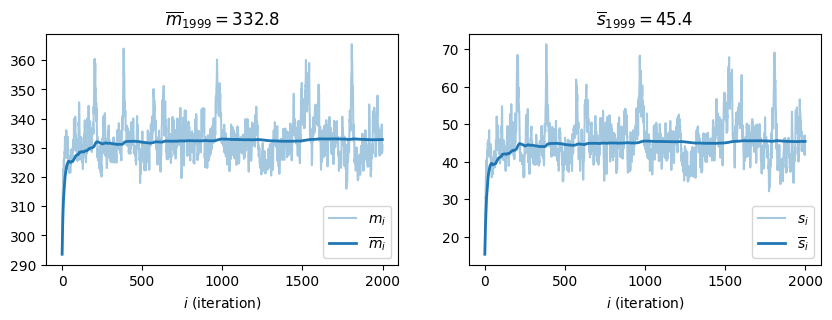

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


k = 300  # weekly Evacado supply
n_iter = 2000
rng = np.random.default_rng(42)

# fmt: off
x = np.array([300, 300, 300, 270, 300, 300, 300, 300, 300, 300, 300, 300, 293,
              300, 300, 300, 300, 300, 291, 300, 300, 300, 300, 300, 214, 246,
              300, 300, 300, 300, 300, 278, 300, 300, 300, 300, 300, 256, 300,
              300, 273, 295, 300, 284, 300, 300, 300, 300, 300, 300, 300, 289,
              300, 300, 300, 279, 300, 300, 272, 300, 300, 300, 283, 278, 300,
              300, 300, 300, 256, 300, 300, 300, 290, 300, 300, 300, 300, 263,
              300, 300, 300, 300, 257, 274, 300, 300, 296, 300, 300, 300, 300,
              300, 300, 300, 300, 232, 300, 300, 265, 300, 296, 300, 300, 300])
# fmt: on


def sample_from_truncated_normal(m, s):
    """Draw len(x) samples from the normal distribution with mean `m` and
    standard deviation `s` conditioned on those samples being >= k."""
    return stats.truncnorm.rvs(
        (k - m) / s, np.inf, loc=m, scale=s, size=len(x), random_state=rng
    )


Y = np.zeros((n_iter, len(x)))
Y[0] = x
m = np.zeros(n_iter)
s = np.zeros(n_iter)

for i in range(n_iter):
    m[i] = Y[i].mean()
    s[i] = Y[i].std()
    if i < n_iter - 1:
        Y[i + 1] = np.where(x < k, x, sample_from_truncated_normal(m[i], s[i]))

m_bar = np.cumsum(m) / np.arange(1, n_iter + 1)
s_bar = np.cumsum(s) / np.arange(1, n_iter + 1)


fig, [m_ax, s_ax] = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharex=True)
m_ax.plot(m, alpha=0.4, label="$m_i$")
m_ax.plot(
    m_bar,
    "C0",
    lw=2,
    label="$\\overline{m}_i$",
)
m_ax.set_xlabel("$i$ (iteration)")
m_ax.legend(loc="lower right")
m_ax.set_title(f"$\\overline{{m}}_{{ {n_iter - 1} }} = {m_bar[-1].round(1)}$")

s_ax.plot(s, alpha=0.4, label="$s_i$")
s_ax.plot(
    s_bar,
    "C0",
    lw=2,
    label="$\\overline{s}_i$",
)
s_ax.set_xlabel("$i$ (iteration)")
s_ax.legend(loc="lower right")
s_ax.set_title(f"$\\overline{{s}}_{{ {n_iter - 1} }} = {s_bar[-1].round(1)}$")

plt.show()

## Optimizing Eva's avocado order

Suppose Eva buys her avocados for \$1 and sells them (rebranded to Evacados) for \$2.

**Your tasks:**

1. Simulate 10,000 weeks of Evacado demand using your demand model $N(\overline{m}_{1999}, \overline{s}_{1999}^2)$.

2. Use this demand data to estimate Eva's expected weekly profits with an on of $k$ avocados per week, $k\leq 290\lt 370$.
Plot expected weekly profits versus $k$.

3. Which $k$ maximizes expected profits?
What is the corresponding increase in expected profits over her standing order of 300 avocados per week?

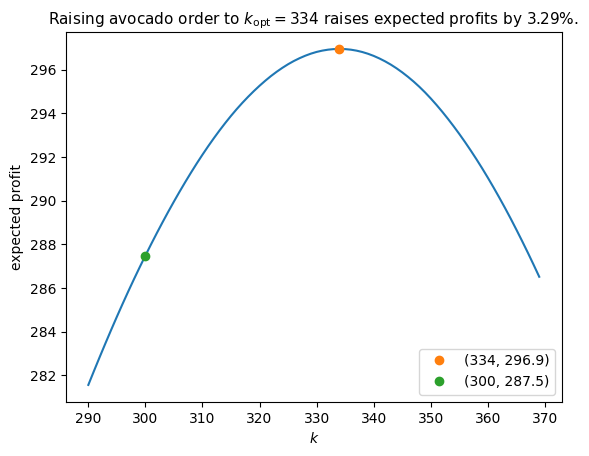

In [7]:
unit_cost = 1.0
unit_revenue = 2.0

demand = rng.normal(m_bar[-1], s_bar[-1], size=(10_000, 1))
ks = np.arange(290, 370)
ks = np.arange(290, 370)
sales = np.minimum(ks[None, :], demand)
exp_sales = sales.mean(axis=0)
exp_profit = exp_sales * unit_revenue - ks * unit_cost
opt_k = ks[exp_profit.argmax()]
opt_exp_profit = exp_profit.max()
exp_profit_300 = exp_profit[np.argmax(ks == 300)]
exp_profit_percent_change = 100 * (opt_exp_profit - exp_profit_300) / exp_profit_300

plt.plot(ks, exp_profit)
plt.plot(
    opt_k,
    opt_exp_profit,
    "o",
    label=f"({opt_k}, {opt_exp_profit.round(1)})",
)
plt.plot(300, exp_profit_300, "o", label=f"(300, {exp_profit_300.round(1)})")
plt.xlabel("$k$")
plt.ylabel("expected profit")
plt.legend(loc="lower right")
plt.title(
    f"Raising avocado order to $k_{{ \\text{{opt}} }}={opt_k}$ raises expected profits by {exp_profit_percent_change:.2f}%.",
    fontsize=11,
)
plt.show()

## Incorporating price-elasticity of demand

Your other cousin Avi owns another gourmet fruit and vegetable store and wants your help optimizing his avocado (or, as he calls them, Avicado) sales.
He gets a shipment of 300 avocados at the beginning of every week, and sells out about half the time.
He doesn't carry over Avicado stock week-to-week. 

Avi wants your help "data science-ing" his sales records from the last two years to better estimate Avicado demand, with an eye to optimizing his weekly order.
Here's a sketch of how you might proceed:

Avicado prices and demand both fluctuate week-to-week.
Let $p_i$ be the avocado price for week $i$ (known) and let $y_i$ be the Avicado demand (unknown if Avi sells out).
Model the expected Avicado demand $\mu(p)=\mathbb{E}[y_i\mid p_i]=\mu(p)$ at price $p$  as a linear function of $p$:
$$
\mu(p_i) = \alpha + \beta p_i
$$
Model $y_i$ as a normally distributed random variable with mean $\mu_i$ and homoskedastic standard deviation $\sigma$:
$$
y_i\sim N(\alpha + \beta p_i, \sigma^2)
$$
In this exercise, we develop an approach to estimating $\alpha$ and $\beta$, and $\sigma$.

Let $x_i$ be the number of Avicados sold in week $i$; this is our dataset.
Note that $x_i\leq 300$.
If $x_i \lt 300$, then $y_i=x_i$. If, on the other hand, $x_i=300$, then we don't know what $y_i$ is.

Given initial estimates $a$, $b$, and $s$ of $\alpha$, $\beta$, and $\sigma$, we take guess $Y_i$ at (jargon: **impute**) the true Avicado demand $y_i$ for week $i$.
If $x_i < 300$, set $Y_i=x_i$.
If, on the other hand, $x_i = 300$, draw samples from $N(a + b p_i, s^2)$ until we get one that's $\geq 300$; call it $Y_i$.

Now use the imputed demands $Y_i$ to update your estimates of $\alpha$, $\beta$, and $\sigma$ by fitting a linear regression of $Y$ on $p$.

We've designed a mechanism that takes, as input, a triple $(a, b, s)$ and produces, as output, a hopefully improved version $(a', b', s')$.
We can iterate this process, hopefully converging on good estimates of $\alpha$, $\beta$ and $\sigma$.
Kick the process off by initializing $Y$ to $x$.


**Your task:**
Implement this scheme for estimating $\beta_0$, $\beta$, and $\sigma$.

- Start by computing vectors `a`, `b`, and `s` of length `n_iter` (2000) containing your sequence of estimates of $\beta_0$, $\beta$, and $\sigma$, and plotting them.
(I provided the plotting code below.)

- You should notice that `a` and `b`, and `s` are noisy.
Smooth them out by averaging.
Specifically, compute vectors `a_bar`, `b_bar`, and `s_bar` of length `n_iter` whose `i`-th enties are the averages of `a[:i + 1]` and `b[:i + 1]`, and `s[:i + 1]`.
Plot these, too; again, I provided the plotting code.

- Your final estimates of $\beta_0$, $\beta$, and $\sigma$ are `a_bar[-1]`, `b_bar[-1]`, and `s_bar[-1]`.

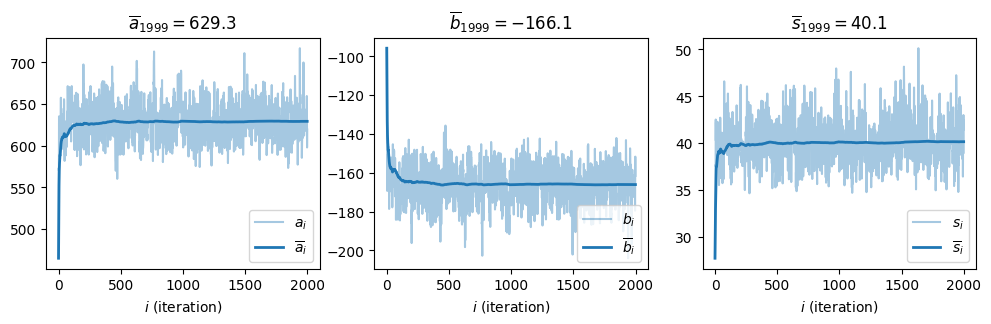

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error  # How might this be useful?


k = 300  # weekly Evacado supply
n_iter = 2000
rng = np.random.default_rng(42)

# fmt: off
p =  np.array([2.04, 1.96, 2.19, 2.03, 1.84, 2.11, 2.39, 2.28, 1.79, 1.62, 1.81,
                   2.01, 1.3 , 1.93, 1.63, 1.78, 1.84, 1.91, 2.12, 2.31, 1.96, 2.41,
                   1.8 , 2.11, 2.27, 2.03, 1.78, 1.72, 1.86, 2.07, 1.7 , 1.94, 1.95,
                   2.16, 2.06, 2.11, 1.8 , 1.96, 2.24, 2.45, 1.62, 2.45, 2.4 , 2.23,
                   2.08, 1.91, 2.44, 2.59, 2.54, 2.39, 2.11, 1.64, 2.  , 2.2 , 1.61,
                   2.12, 2.13, 2.21, 1.64, 1.8 , 1.87, 1.65, 2.52, 1.85, 2.1 , 1.92,
                   2.48, 2.4 , 2.19, 1.34, 2.02, 2.21, 2.3 , 1.81, 2.55, 1.6 , 1.8 ,
                   2.28, 2.01, 2.6 , 2.06, 1.81, 1.89, 1.67, 1.62, 2.19, 2.17, 2.39,
                   1.77, 2.51, 1.91, 2.47, 1.87, 1.78, 2.07, 2.31, 2.05, 1.82, 1.6 ,
                   1.58, 2.15, 2.3 , 1.95, 1.68])

x = np.array([300, 254, 242, 300, 233, 298, 218, 262, 300, 300, 300, 268, 300,
                   300, 300, 300, 300, 300, 285, 196, 300, 207, 273, 293, 236, 254,
                   291, 300, 300, 300, 300, 300, 300, 300, 196, 300, 300, 300, 278,
                   247, 300, 218, 163, 261, 255, 300, 222, 214, 185, 221, 283, 294,
                   300, 265, 300, 186, 300, 256, 300, 300, 300, 300, 225, 263, 300,
                   300, 270, 241, 300, 300, 300, 262, 196, 300, 140, 300, 300, 216,
                   300, 201, 273, 300, 297, 300, 300, 252, 196, 189, 300, 221, 300,
                   295, 268, 300, 270, 276, 265, 300, 295, 300, 300, 235, 300, 296])
# fmt: on


def sample_from_truncated_normal(m, s):
    """Draw len(x) samples from the normal distribution with mean `m` and
    standard deviation `s` conditioned on those samples being >= k."""
    return stats.truncnorm.rvs(
        (k - m) / s, np.inf, loc=m, scale=s, size=len(x), random_state=rng
    )


Y = np.zeros((n_iter, len(x)))
Y[0] = x
a = np.zeros(n_iter)
b = np.zeros(n_iter)
s = np.zeros(n_iter)
model = LinearRegression()

for i in range(n_iter):
    model.fit(p.reshape(-1, 1), Y[i])
    a[i] = model.intercept_
    b[i] = model.coef_.item()
    Y_pred = model.predict(p.reshape(-1, 1))
    s[i] = root_mean_squared_error(Y[i], Y_pred)
    # Y = np.where(Y < 300, Y, sample_from_truncated_normal(Y_pred, s[i]))
    if i < n_iter - 1:
        Y[i + 1] = np.where(x < k, x, sample_from_truncated_normal(Y_pred, s[i]))


a_bar = np.cumsum(a) / np.arange(1, n_iter + 1)
b_bar = np.cumsum(b) / np.arange(1, n_iter + 1)
s_bar = np.cumsum(s) / np.arange(1, n_iter + 1)


fig, [a_ax, b_ax, s_ax] = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharex=True)
a_ax.plot(a, alpha=0.4, label="$a_{i}$")
a_ax.plot(
    a_bar,
    "C0",
    lw=2,
    label="$\\overline{a}_{i}$",
)
a_ax.set_xlabel("$i$ (iteration)")
a_ax.legend(loc="lower right")
a_ax.set_title(f"$\\overline{{a}}_{{ {n_iter - 1} }} = {a_bar[-1].round(1)}$")

b_ax.plot(b, alpha=0.4, label="$b_{i}$")
b_ax.plot(
    b_bar,
    "C0",
    lw=2,
    label="$\\overline{b}_{i}$",
)
b_ax.set_xlabel("$i$ (iteration)")
b_ax.legend(loc="lower right")
b_ax.set_title(f"$\\overline{{b}}_{{ {n_iter - 1} }} = {b_bar[-1].round(1)}$")

s_ax.plot(s, alpha=0.4, label="$s_i$")
s_ax.plot(
    s_bar,
    "C0",
    lw=2,
    label="$\\overline{s}_{i}$",
)
s_ax.set_xlabel("$i$ (iteration)")
s_ax.legend()
s_ax.set_title(f"$\\overline{{s}}_{{{n_iter - 1} }} = {s_bar[-1].round(1)}$")

plt.show()

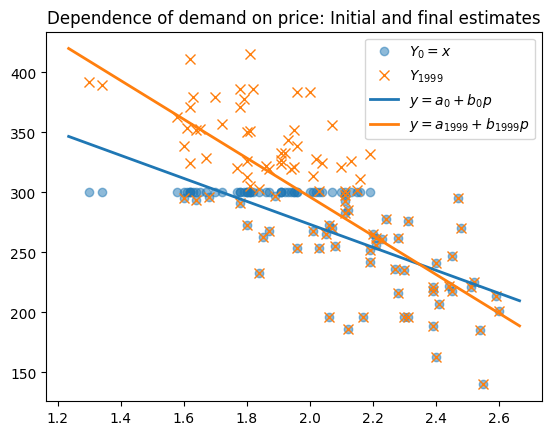

In [10]:
plt.plot(p, Y[0], "o", alpha=0.5, label="$Y_0=x$")
plt.plot(p, Y[-1], "x", ms=7, alpha=1, label=f"$Y_{{ {n_iter - 1} }}$")
t = np.linspace(*plt.xlim())
plt.plot(t, a[0] + b[0] * t, "C0", lw=2, label="$y = a_0 + b_0 p$")
plt.plot(
    t,
    a[-1] + b[-1] * t,
    "C1",
    lw=2,
    label=f"$y = a_{{ {n_iter - 1} }} + b_{{ {n_iter - 1} }} p$",
)
plt.legend()
plt.title("Dependence of demand on price: Initial and final estimates")
plt.show()

## Optimizing Avi's avocado order

Suppose Avi always sells an Avicado for twice what he paid for it.

1. For each week $i$, how many avocados should Avi have ordered for $p_i/2$ dollars and sold (as Avicados) for $p_i$ dollars to maximize his excpected profits, according to your model? Do this by simulation, as in Eva's case.

2. By how what percentage would you expect his profits to have increased by following this strategy instead of simply ordering 300 avocados every week?

In [99]:
e = s_bar[-1] * rng.normal(size=(10_000, 1))
ks = np.arange(180, 420)

best_profit = np.zeros_like(p)
best_k = np.zeros_like(p, dtype=int)

for i, p_i in enumerate(p):
    demand = a_bar[-1] + b_bar[-1] * p_i + e
    sales = np.minimum(ks, demand)
    profit = sales * p_i - ks * p_i / 2
    exp_profit = profit.mean(axis=0)
    best_profit[i] = exp_profit.max()
    best_k[i] = ks[exp_profit.argmax()]

print("Had Avi's weekly avocado orders been\n")
print(best_k)

a = best_profit.sum()  # profit with optimized order
b = np.sum(
    x * p - 300 * p / 2
)  # Avi's actual profit over the two years, computed from data
c = (a - b) / b  # relative change in profit

print(f"\nhis profits would have been {100*c:.1f}% higher according to our model.")

Had Avi's weekly avocado orders been

[290 303 265 292 323 278 232 250 332 360 328 295 413 308 358 333 323 312
 277 245 303 229 330 278 252 292 333 343 320 285 347 307 305 270 287 278
 330 303 257 222 360 222 230 259 283 312 224 199 207 232 278 357 297 264
 362 277 275 262 357 330 318 355 210 322 280 310 217 230 265 406 293 262
 247 328 205 363 330 250 295 197 287 328 315 352 360 265 269 232 335 212
 312 219 318 333 285 245 288 327 363 367 272 247 305 350]

his profits would have been 8.3% higher according to our model.


**Remarks:**

- Of course, Avi couldn't have actually made these orders over the last two years because we needed the data from that period to predict the optimal orders in the first place.

- If the distribution of wholesale avocado prices is stationary (doesn't depend on time), then Avi can expect the same increase in profits going forward.